### **Importing Libraries**

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb
from skimage.feature import hog
from skimage import exposure
import seaborn as sns
import copy
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torchvision.models as models
import tqdm
from torchvision import transforms
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances
from collections import defaultdict
from joblib import Parallel, delayed

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **Loading Dataset**

In [3]:
def load_data():
    train_embeddings = torch.load("./Dataset/train_embeddings.pth")
    train_labels = torch.load("./Dataset/train_labels.pth")
    test_embeddings = torch.load("./Dataset/test_embeddings.pth")
    test_labels = torch.load("./Dataset/test_labels.pth")
    text_embeddings = torch.load("./Dataset/text_embedding.pth")
    return train_embeddings, train_labels, test_embeddings, test_labels, text_embeddings

train_embeddings, train_labels, test_embeddings, test_labels, text_embeddings = load_data()

train_embeddings_cpu = train_embeddings.cpu().numpy()
train_labels_cpu = train_labels.cpu().numpy()
test_embeddings_cpu = test_embeddings.cpu().numpy()
test_labels_cpu = test_labels.cpu().numpy()
text_embeddings_cpu = text_embeddings.cpu().numpy()

print("Train embeddings shape:", train_embeddings_cpu.shape)
print("Test embeddings shape:", test_embeddings_cpu.shape)

Train embeddings shape: (50000, 512)
Test embeddings shape: (10000, 512)


### **Visualization of Data**

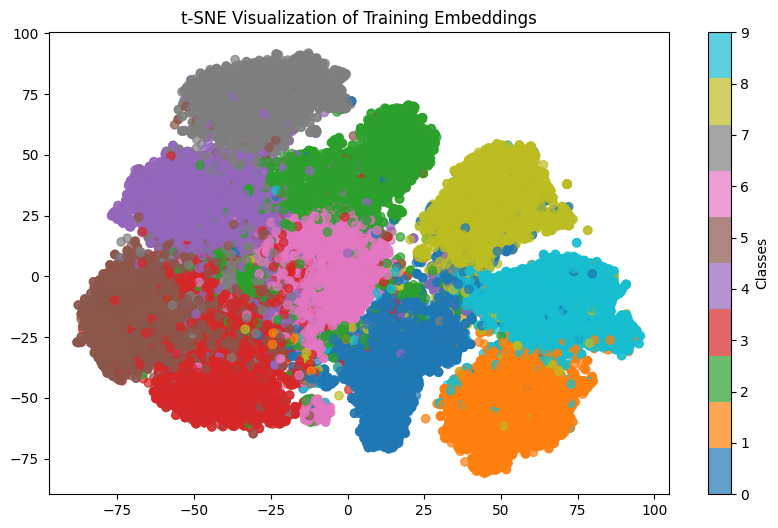

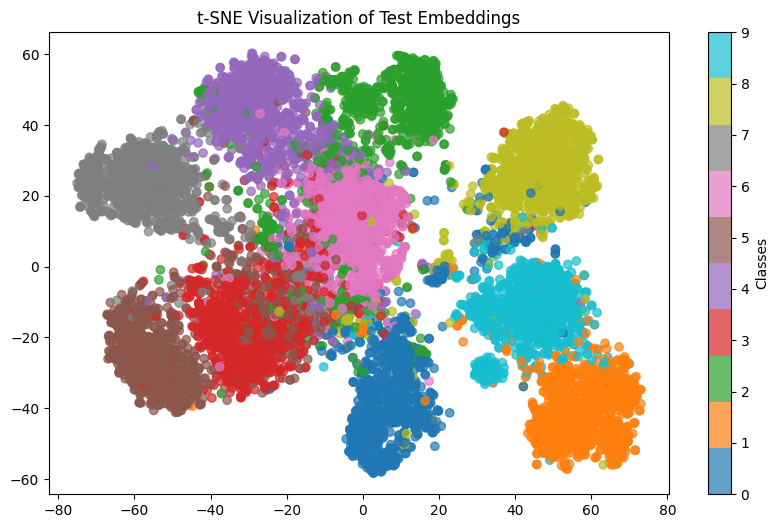

In [3]:
def visualize_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Classes')
    plt.title(title)
    plt.show()

visualize_tsne(train_embeddings_cpu, train_labels_cpu, "t-SNE Visualization of Training Embeddings")
visualize_tsne(test_embeddings_cpu, test_labels_cpu, "t-SNE Visualization of Test Embeddings")

### **3.1**

#### **KNN Function**

In [3]:
def euclidean_distance(x1, x2):
    return cdist(x1, x2.reshape(1, -1), metric='euclidean').flatten()

def cosine_distance(x1, x2):
    return cdist(x1, x2.reshape(1, -1), metric='cosine').flatten()

def knn(train_embeddings, queries, k, metric="euclidean", return_comparisons=False):
    if metric == "euclidean":
        distances = cdist(queries, train_embeddings, metric='euclidean')
    elif metric == "cosine":
        distances = cdist(queries, train_embeddings, metric='cosine')
    else:
        raise ValueError("Unsupported distance metric. Use 'euclidean' or 'cosine'.")

    nearest_neighbors = np.argsort(distances, axis=1)[:, :k]
    
    comparisons = len(train_embeddings)
    
    if return_comparisons:
        return nearest_neighbors, comparisons
    else:
        return nearest_neighbors

#### **Task-1.1 Classification**

In [30]:
def classify(train_embeddings, train_labels, test_embeddings, test_labels, k, metric="euclidean", n_jobs=-1):
    knn_indices = knn(train_embeddings, test_embeddings, k, metric)
    
    def predict(i):
        return np.bincount(train_labels[knn_indices[i]]).argmax() == test_labels[i]
    
    results = Parallel(n_jobs=n_jobs)(delayed(predict)(i) for i in range(len(test_labels)))
    return np.mean(results)

k_values = [1, 5, 10]
distance_metrics = ["euclidean", "cosine"]

for k in k_values:
    for metric in distance_metrics:
        accuracy = classify(train_embeddings_cpu, train_labels_cpu, test_embeddings_cpu, test_labels_cpu, k, metric)
        print(f"K={k}, Metric={metric}, Accuracy={accuracy:.4f}")

K=1, Metric=euclidean, Accuracy=0.9048
K=1, Metric=cosine, Accuracy=0.9048
K=5, Metric=euclidean, Accuracy=0.9182
K=5, Metric=cosine, Accuracy=0.9182
K=10, Metric=euclidean, Accuracy=0.9194
K=10, Metric=cosine, Accuracy=0.9194


#### **Task-1.2 Classification**

In [31]:
def classify_text_embeddings(text_embeddings, test_embeddings, test_labels, k=1, metric="euclidean"):
    correct = 0
    total = len(test_labels)

    all_predicted = []
    all_true = []

    knn_indices = knn(text_embeddings, test_embeddings, k, metric)
    
    for i in range(total):
        predicted_label = knn_indices[i][0]
        true_label = test_labels[i]

        all_predicted.append(predicted_label)
        all_true.append(true_label)

        correct += (predicted_label == true_label)

    accuracy = correct / total

    precision = precision_score(all_true, all_predicted, average='weighted', zero_division=0)
    recall = recall_score(all_true, all_predicted, average='weighted', zero_division=0)
    f1 = f1_score(all_true, all_predicted, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

distance_metrics = ["euclidean", "cosine"]

for metric in distance_metrics:
    accuracy, precision, recall, f1 = classify_text_embeddings(
        text_embeddings_cpu, test_embeddings_cpu, test_labels_cpu, k=1, metric=metric
    )
    print(f"K=1, Metric={metric}, Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

K=1, Metric=euclidean, Accuracy=0.8781, Precision=0.8819, Recall=0.8781, F1 Score=0.8781
K=1, Metric=cosine, Accuracy=0.8781, Precision=0.8819, Recall=0.8781, F1 Score=0.8781


#### **Task-2.1 Retrieval**

In [5]:
def mean_reciprocal_rank(indices, text_labels, image_labels):
    mrr_sum = 0.0
    for i, retrieved in enumerate(indices):
        for rank, idx in enumerate(retrieved):
            if image_labels[idx] == text_labels[i]:
                mrr_sum += 1.0 / (rank + 1)
                break
    return mrr_sum / len(indices)

def precision_at_k(indices, text_labels, image_labels, k=100):
    precision_sum = 0.0
    for i, retrieved in enumerate(indices):
        relevant_retrieved = sum(1 for idx in retrieved[:k] if image_labels[idx] == text_labels[i])
        precision_sum += relevant_retrieved / k
    return precision_sum / len(indices)

def hit_rate_at_k(indices, text_labels, image_labels, k=100):
    hit_rate_sum = 0.0
    for i, retrieved in enumerate(indices):
        if any(image_labels[idx] == text_labels[i] for idx in retrieved[:k]):
            hit_rate_sum += 1
    return hit_rate_sum / len(indices)

def text_to_image_retrieval(train_embeddings, train_labels, text_embeddings, k=100, metric="euclidean"):
    text_labels = np.arange(len(text_embeddings))
    nearest_neighbors_indices = knn(train_embeddings, text_embeddings, k, metric)
    
    mrr = mean_reciprocal_rank(nearest_neighbors_indices, text_labels, np.array(train_labels))
    precision = precision_at_k(nearest_neighbors_indices, text_labels, np.array(train_labels), k)
    hit_rate = hit_rate_at_k(nearest_neighbors_indices, text_labels, np.array(train_labels), k)
    
    return mrr, precision, hit_rate

mrr, precision, hit_rate = text_to_image_retrieval(train_embeddings_cpu, train_labels_cpu, text_embeddings_cpu, k=100)

print(f"Mean Reciprocal Rank: {mrr}")
print(f"Precision@100: {precision}")
print(f"Hit Rate@100: {hit_rate}")


Mean Reciprocal Rank: 1.0
Precision@100: 0.974
Hit Rate@100: 1.0


#### **Task-2.2 Retrieval**

In [7]:
def image_to_image_retrieval(train_embeddings, train_labels, test_embeddings, test_labels, k=100, n_jobs=-1):
    nearest_neighbors_indices, avg_comparisons = knn(train_embeddings, test_embeddings, k, return_comparisons=True)
    
    def compute_metrics(i):
        return (
            mean_reciprocal_rank([nearest_neighbors_indices[i]], [test_labels[i]], train_labels),
            precision_at_k([nearest_neighbors_indices[i]], [test_labels[i]], train_labels, k),
            hit_rate_at_k([nearest_neighbors_indices[i]], [test_labels[i]], train_labels, k)
        )
    
    results = Parallel(n_jobs=n_jobs)(delayed(compute_metrics)(i) for i in range(len(test_labels)))
    
    mrr = np.mean([r[0] for r in results])
    precision = np.mean([r[1] for r in results])
    hit_rate = np.mean([r[2] for r in results])
    
    return mrr, precision, hit_rate, avg_comparisons

mrr, precision, hit_rate, avg_comparisons = image_to_image_retrieval(train_embeddings_cpu, train_labels_cpu, test_embeddings_cpu, test_labels_cpu, k=100)

print(f"Mean Reciprocal Rank: {mrr}")
print(f"Precision@100: {precision}")
print(f"Hit Rate@100: {hit_rate}")
print(f"Average Comparisons per Query: {avg_comparisons}")

Mean Reciprocal Rank: 0.934796151331504
Precision@100: 0.841083
Hit Rate@100: 0.9996
Average Comparisons per Query: 50000


### **3.2**

#### **LSH Implementation**

In [12]:
class LSH:
    def __init__(self, num_planes, dimension):

        self.num_planes = num_planes
        self.dimension = dimension
        self.hyperplanes = np.random.randn(self.num_planes, self.dimension)
        
    def hash(self, vector):

        dot_products = np.dot(self.hyperplanes, vector)
        hash_code = (dot_products > 0).astype(int)
        return hash_code
    
    def fit(self, dataset):

        self.dataset = dataset
        self.hash_codes = np.array([self.hash(vector) for vector in dataset])
        self.hash_buckets = {}
        for idx, code in enumerate(self.hash_codes):
            code_tuple = tuple(code)
            if code_tuple not in self.hash_buckets:
                self.hash_buckets[code_tuple] = []
            self.hash_buckets[code_tuple].append(idx)

    def get_bucket_sizes(self):
        return [len(indices) for indices in self.hash_buckets.values()]
        
    def search(self, query_vector, k=5):

        query_hash = self.hash(query_vector)
        query_hash_tuple = tuple(query_hash)
        
        comparison_count = 0
        
        candidate_indices = []
        if query_hash_tuple in self.hash_buckets:
            candidate_indices = self.hash_buckets[query_hash_tuple]
            comparison_count = len(candidate_indices)
        
        # print(comparison_count)

        if len(candidate_indices) < k:

            all_indices = list(range(len(self.hash_codes)))
            additional_candidates = [
                idx for idx in all_indices 
                if idx not in candidate_indices
            ]
            candidate_indices.extend(additional_candidates[:k-len(candidate_indices)])
            comparison_count += len(additional_candidates[:k-len(candidate_indices)])
        
        if len(candidate_indices) > 0:
            distances = np.array([
                np.sum(query_hash != self.hash_codes[idx]) 
                for idx in candidate_indices
            ])
            nearest_local_indices = np.argsort(distances)[:k]
            return np.array(candidate_indices)[nearest_local_indices], comparison_count
        
        return np.array([]), comparison_count

def compute_metrics(train_embeddings, train_labels, test_embeddings, test_labels, k=5):
    lsh = LSH(num_planes=15, dimension=train_embeddings.shape[1])
    lsh.fit(train_embeddings)
    
    mrr = 0
    precision_at_k = 0
    hit_rate = 0
    total_queries = len(test_embeddings)
    total_comparisons = 0
    
    for query_embedding, query_label in zip(test_embeddings, test_labels):
        retrieved_indices, comparisons = lsh.search(query_embedding, k)
        
        if len(retrieved_indices) == 0:
            continue
        
        retrieved_labels = train_labels[retrieved_indices]
        
        rank = np.where(retrieved_labels == query_label)[0]
        if len(rank) > 0:
            mrr += 1 / (rank[0] + 1)
        
        precision_at_k += np.sum(retrieved_labels == query_label) / k
        
        if np.sum(retrieved_labels == query_label) > 0:
            hit_rate += 1
        
        total_comparisons += comparisons
    
    mrr /= total_queries
    precision_at_k /= total_queries
    hit_rate /= total_queries
    
    avg_comparisons_per_query = total_comparisons / total_queries
    
    return mrr, precision_at_k, hit_rate, avg_comparisons_per_query

#### **Testing**

In [26]:
k = 100
mrr, precision_at_k, hit_rate, avg_comparisons_per_query = compute_metrics(train_embeddings_cpu, train_labels_cpu, test_embeddings_cpu, test_labels_cpu, k)

print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print(f"Precision@{k}: {precision_at_k:.4f}")
print(f"Hit Rate: {hit_rate:.4f}")
print(f"Average Comparisons Per Query: {avg_comparisons_per_query:.0f}")

Mean Reciprocal Rank (MRR): 0.4685
Precision@100: 0.2866
Hit Rate: 0.9894
Average Comparisons Per Query: 1795


#### **Plotting**

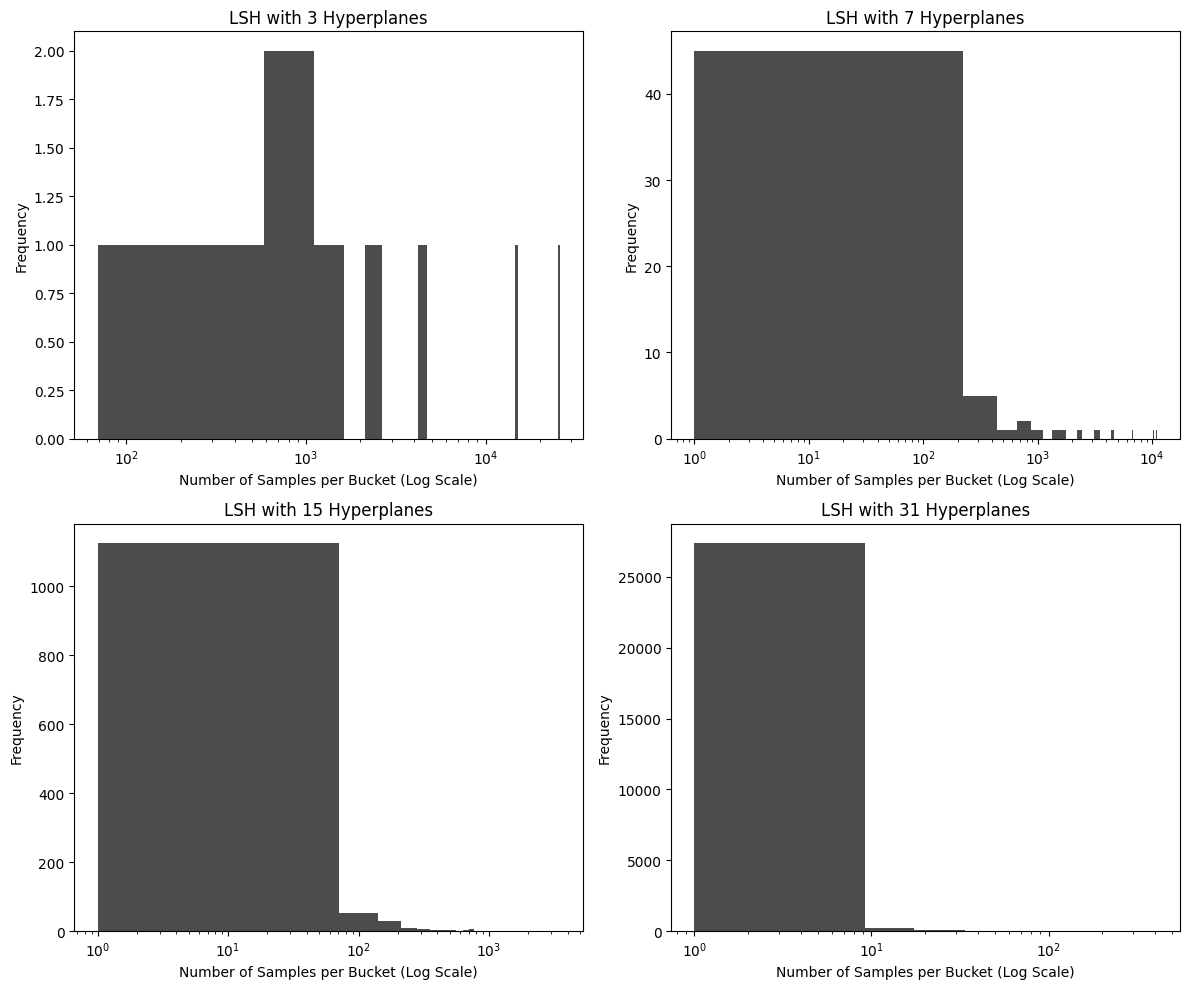

In [14]:
hyperplane_settings = [3, 7, 15, 31]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, num_planes in enumerate(hyperplane_settings):
    lsh = LSH(num_planes=num_planes, dimension=train_embeddings.shape[1])
    lsh.fit(train_embeddings)
    bucket_sizes = lsh.get_bucket_sizes()
    
    row, col = divmod(i, 2)
    axes[row, col].hist(bucket_sizes, bins=50, color='black', alpha=0.7)
    axes[row, col].set_xscale('log')
    axes[row, col].set_xlabel("Number of Samples per Bucket (Log Scale)")
    axes[row, col].set_ylabel("Frequency")
    axes[row, col].set_title(f"LSH with {num_planes} Hyperplanes")

plt.tight_layout()
plt.show()

##### **Problem Observed**

**Skewed Bucket Distributions:**

- The histograms for 15 and 31 hyperplanes are dominated by a single bar, indicating that most buckets contain only one or very few samples.
- This suggests that the number of hyperplanes is too high, causing excessive partitioning, leading to sparsely populated buckets.

##### Effect of Varying Number of Hyperplanes on Performance Metrics


**Effect of Increasing the Number of Hyperplanes**

1. **Mean Reciprocal Rank (MRR)**
- **Trend:** MRR tends to **increase initially** and then **decrease** after an optimal number of hyperplanes.
- **Reason:** More hyperplanes create finer partitions, improving rank ordering of retrieved neighbors. However, excessive partitioning may over-fragment data, leading to missing relevant neighbors.

1. **Precision@100**
- **Trend:** Precision@100 generally **increases** with more hyperplanes until it stabilizes or slightly declines.
- **Reason:** More hyperplanes improve the quality of retrieved results by reducing false positives. However, excessive partitioning can cause relevant items to be assigned to different buckets, leading to missed results.

3. **Hit Rate**
- **Trend:** Hit Rate remains **high** but may decrease slightly for very high hyperplane numbers.
- **Reason:** The system continues to find relevant neighbors, but extreme fragmentation causes some queries to miss relevant results, reducing hit rate marginally.

4. **Average Comparisons Per Query**
- **Trend:** Comparisons per query **decrease initially**, then **increase sharply** with more hyperplanes.
- **Reason:**
  - Initially, LSH reduces search space, decreasing comparisons.
  - Excessive hyperplanes cause many small buckets, forcing a fallback to exhaustive search in some cases, increasing comparisons.



### **3.3**

#### **IVF Implementation**

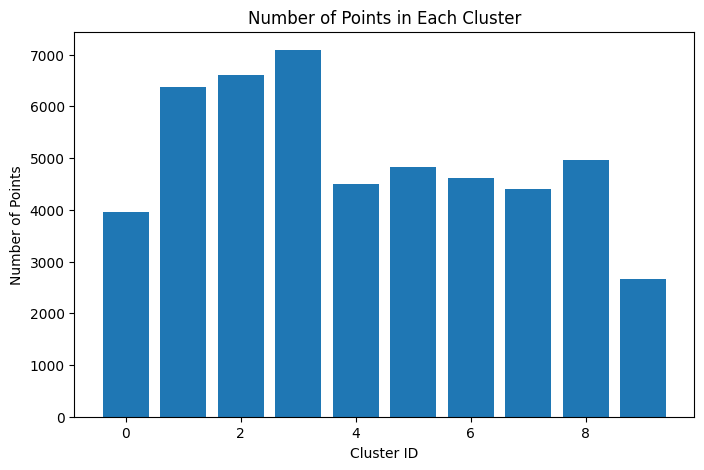

In [6]:
def train_ivf(train_embeddings, train_labels, num_clusters=10):

    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(train_embeddings)
    
    ivf_index = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_assignments):
        ivf_index[cluster_id].append((train_embeddings[idx], idx, train_labels[idx]))
    
    cluster_counts = np.bincount(cluster_assignments, minlength=num_clusters)
    plt.figure(figsize=(8, 5))
    plt.bar(range(num_clusters), cluster_counts)
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Points")
    plt.title("Number of Points in Each Cluster")
    plt.show()
    
    return kmeans, ivf_index

def search_ivf(query_embedding, kmeans, ivf_index, nprobe=1, top_k=100):

    cluster_distances = cdist(query_embedding.reshape(1, -1), kmeans.cluster_centers_)
    nearest_clusters = np.argsort(cluster_distances[0])[:nprobe]
    
    candidates = []
    candidate_ids = []
    candidate_labels = []
    comparisons = 0
    for cluster_id in nearest_clusters:
        cluster_data = ivf_index.get(cluster_id, [])
        comparisons += len(cluster_data)
        for embedding, idx, label in cluster_data:
            candidates.append(embedding)
            candidate_ids.append(idx)
            candidate_labels.append(label)
    
    candidates = np.array(candidates)
    
    if len(candidates) > 0:
        distances = cdist(query_embedding.reshape(1, -1), candidates)[0]
        top_indices = np.argsort(distances)[:top_k]
        return [candidate_ids[i] for i in top_indices], [candidate_labels[i] for i in top_indices], comparisons
    else:
        return [], [], comparisons

def mean_reciprocal_rank(retrieved_labels, ground_truth_label):
    for rank, label in enumerate(retrieved_labels, start=1):
        if label == ground_truth_label:
            return 1 / rank
    return 0

def precision_at_k(retrieved_labels, ground_truth_label, k=100):
    return sum(1 for label in retrieved_labels[:k] if label == ground_truth_label) / k

def hit_rate(retrieved_labels, ground_truth_label):
    return int(any(label == ground_truth_label for label in retrieved_labels))

def evaluate_retrieval(test_embeddings, test_labels, kmeans, ivf_index, nprobe=1, top_k=100):
    mrr, precision, hit = 0, 0, 0
    total = len(test_embeddings)
    total_comparisons = 0
    
    for i, query in enumerate(test_embeddings):
        ground_truth_label = test_labels[i]
        retrieved, retrieved_labels, comparisons = search_ivf(query, kmeans, ivf_index, nprobe, top_k)
        
        mrr += mean_reciprocal_rank(retrieved_labels, ground_truth_label)
        precision += precision_at_k(retrieved_labels, ground_truth_label, top_k)
        hit += hit_rate(retrieved_labels, ground_truth_label)
        total_comparisons += comparisons
    
    return {
        "MRR": mrr / total,
        "Precision@100": precision / total,
        "Hit Rate": hit / total,
        "Avg Comparisons per Query": total_comparisons / total
    }

num_clusters = 10
kmeans, ivf_index = train_ivf(train_embeddings_cpu, train_labels_cpu, num_clusters)

In [7]:
nprobe_values = [3, 5]

for nprobe in nprobe_values:
    metrics = evaluate_retrieval(test_embeddings_cpu, test_labels_cpu, kmeans, ivf_index, nprobe, top_k=100)
    print(f"Results for nprobe={nprobe}:")
    print(f"MRR: {metrics['MRR']:.4f}")
    print(f"Precision@100: {metrics['Precision@100']:.4f}")
    print(f"Hit Rate: {metrics['Hit Rate']:.4f}")
    print(f"Avg Comparisons per Query: {metrics['Avg Comparisons per Query']:.2f}")
    print("-" * 50)


Results for nprobe=3:
MRR: 0.9344
Precision@100: 0.8417
Hit Rate: 0.9993
Avg Comparisons per Query: 16174.08
--------------------------------------------------
Results for nprobe=5:
MRR: 0.9347
Precision@100: 0.8412
Hit Rate: 0.9995
Avg Comparisons per Query: 26092.34
--------------------------------------------------


#### **Plotting**

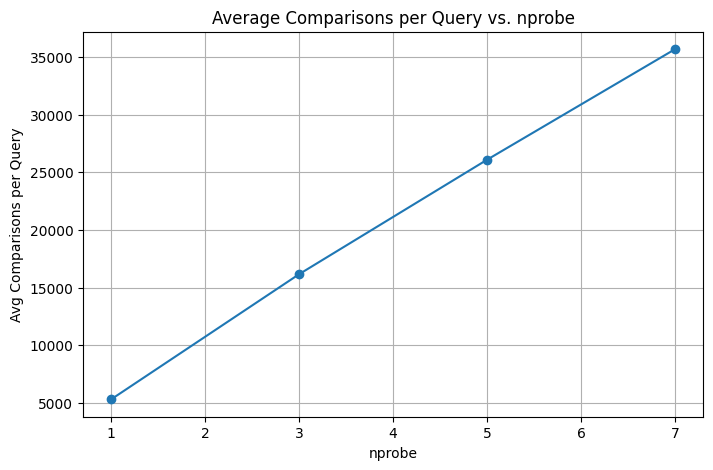

In [27]:
def plot_comparisons_vs_nprobe(nprobe_values, comparisons_per_query):
    plt.figure(figsize=(8, 5))
    plt.plot(nprobe_values, comparisons_per_query, marker='o', linestyle='-')
    plt.xlabel("nprobe")
    plt.ylabel("Avg Comparisons per Query")
    plt.title("Average Comparisons per Query vs. nprobe")
    plt.grid()
    plt.show()

nprobe_values = [1, 3, 5, 7]
comparisons_per_query = []

for nprobe in nprobe_values:
    metrics = evaluate_retrieval(test_embeddings_cpu, test_labels_cpu, kmeans, ivf_index, nprobe, top_k=100)
    comparisons_per_query.append(metrics['Avg Comparisons per Query'])

plot_comparisons_vs_nprobe(nprobe_values, comparisons_per_query)

### **Analysis**

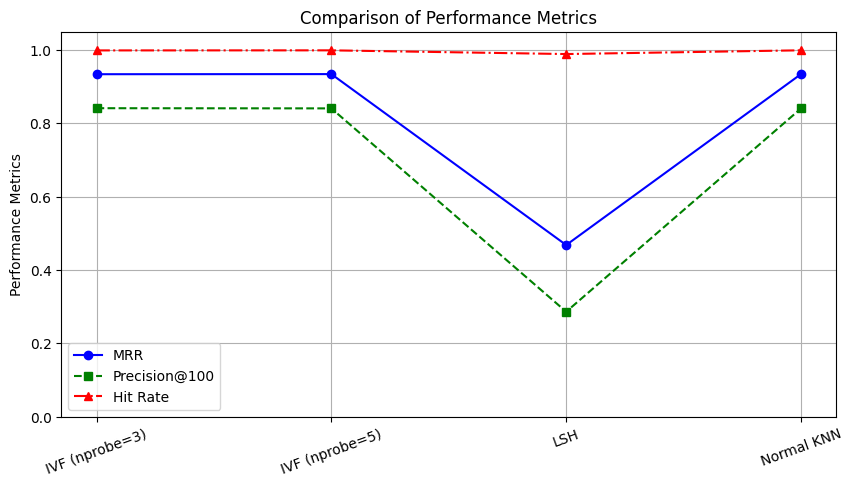

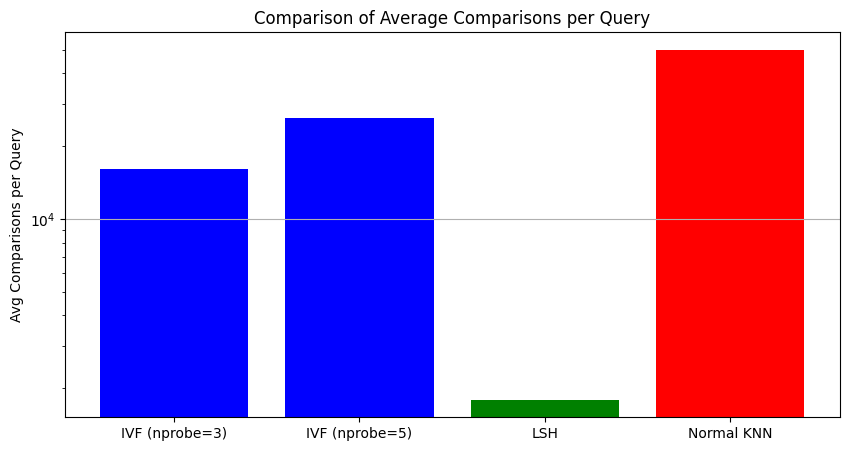

In [15]:
methods = ["IVF (nprobe=3)", "IVF (nprobe=5)", "LSH", "Normal KNN"]
MRR = [0.9344, 0.9347, 0.4685, 0.9348]
Precision = [0.8417, 0.8412, 0.2866, 0.8411]
Hit_Rate = [0.9993, 0.9995, 0.9894, 0.9996]
Avg_Comparisons = [16174.08, 26092.34, 1795, 50000]

x = np.arange(len(methods))

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(x, MRR, marker='o', label="MRR", color='b', linestyle='-')
ax1.plot(x, Precision, marker='s', label="Precision@100", color='g', linestyle='--')
ax1.plot(x, Hit_Rate, marker='^', label="Hit Rate", color='r', linestyle='-.')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=20)
ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Performance Metrics")
ax1.set_title("Comparison of Performance Metrics")
ax1.legend()
ax1.grid()

fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.bar(methods, Avg_Comparisons, color=['blue', 'blue', 'green', 'red'])
ax2.set_ylabel("Avg Comparisons per Query")
ax2.set_title("Comparison of Average Comparisons per Query")
ax2.set_yscale("log")
ax2.grid(axis='y')

plt.show()

#### **Explanation of Trends:**

- Normal KNN achieves the best performance (MRR, Precision, and Hit Rate) but requires the highest number of comparisons per query.
- IVF (nprobe=3,5) maintains high performance while reducing the number of comparisons significantly compared to Normal KNN. Increasing nprobe improves accuracy but increases computations.
- LSH is the most efficient in terms of comparisons but sacrifices significant accuracy, making it less suitable when high precision is needed.